In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# import mitrate data

argo = pd.read_csv('../data/argo/7546KUROSHIOQC.txt', sep = ',')
argo2 = pd.read_csv('../data/argo/7674KUROSHIOQC.txt', sep = ',')

argo = argo.append(argo2,ignore_index=True)

month = []
for n in range(len(argo)):
    month.append(np.int(str(argo['Date/GMT'][n]).split('/')[0].lstrip('0   ')))

argo['MONTH'] = month


argo = argo[(argo['LON']>140) & (argo['LON']<160) & (argo['LAT']>30) & (argo['LAT']<45)]

print len(argo)


8579


143


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


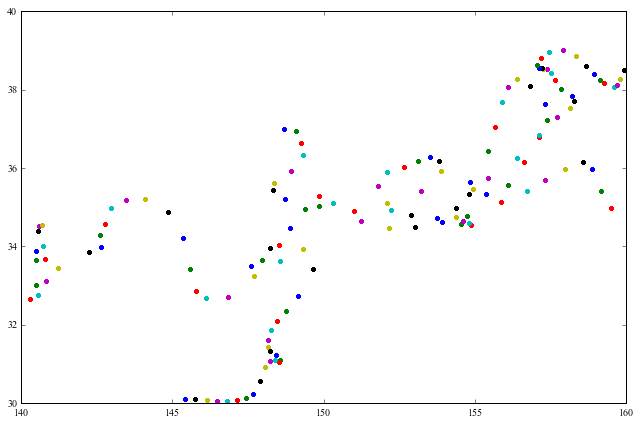

['03/01/2013 06:15' '03/06/2013 09:51' '03/11/2013 13:31'
 '03/16/2013 17:25' '03/21/2013 21:24' '03/27/2013 00:33'
 '04/01/2013 04:10' '04/06/2013 08:35' '04/11/2013 13:39'
 '04/16/2013 17:13' '04/21/2013 20:22' '04/26/2013 23:41'
 '05/02/2013 03:01' '05/07/2013 06:33' '05/12/2013 10:19'
 '05/17/2013 15:01' '05/22/2013 18:46' '05/27/2013 22:12'
 '06/02/2013 02:14' '06/07/2013 06:59' '06/12/2013 11:25'
 '06/17/2013 15:11' '06/22/2013 19:06' '06/28/2013 00:20'
 '07/03/2013 04:30' '07/08/2013 08:59' '07/13/2013 13:19'
 '07/18/2013 17:16' '07/23/2013 21:33' '08/22/2015 08:23'
 '08/27/2015 13:20' '09/01/2015 17:46' '09/06/2015 22:55'
 '09/12/2015 05:50' '09/17/2015 12:12' '09/22/2015 17:34'
 '09/27/2015 22:25' '10/03/2015 02:11' '10/08/2015 06:07'
 '10/13/2015 10:45' '10/18/2015 15:09' '10/23/2015 19:48'
 '10/28/2015 23:38' '11/03/2015 04:57' '11/08/2015 10:02'
 '11/13/2015 15:31' '11/18/2015 20:11' '11/24/2015 02:26'
 '11/29/2015 07:05' '12/04/2015 11:12' '12/09/2015 18:05'
 '12/14/2015 2

In [3]:
days = pd.unique(argo['Days since 1/1/1900'])
print len(days)

fig1 = plt.figure(1, figsize=(9, 6))

for d in days:
    subsetd = argo[argo['Days since 1/1/1900']==d]
    plt.plot(subsetd['LON'], subsetd['LAT'], '.-')
    
plt.show()

print pd.unique(argo['Date/GMT'])

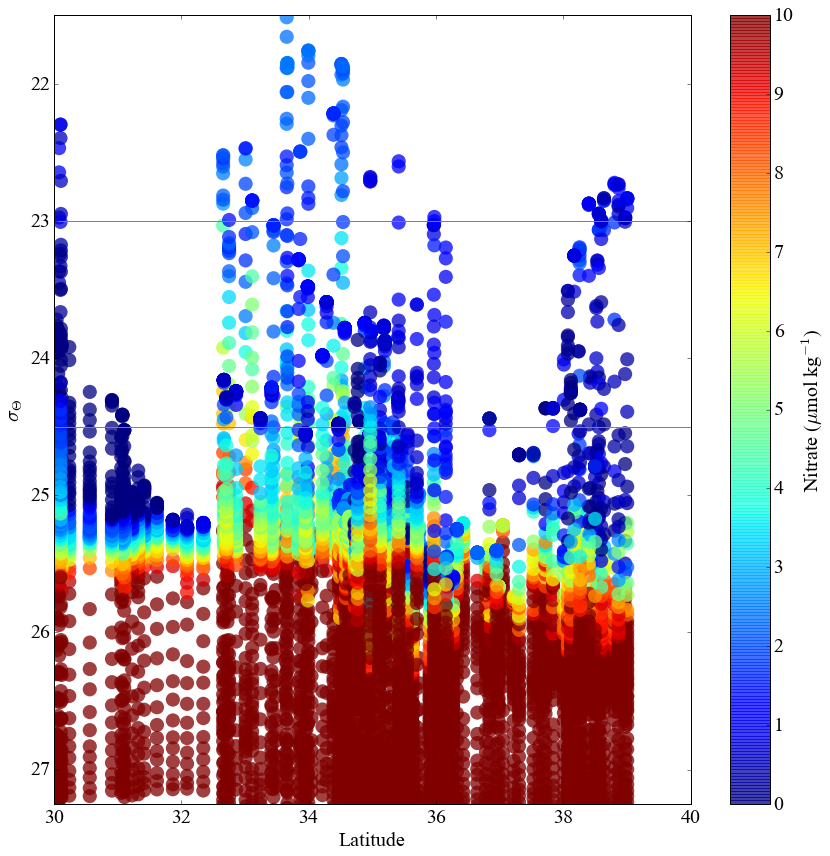

In [10]:
subset = argo

fig1 = plt.figure(1, figsize=(12,12))
plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 10, lw=0, alpha = 0.75)
#plt.contour()
cb = plt.colorbar()
cb.set_label('Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 20)
plt.gca().invert_yaxis()
plt.axis([ 30,40, 27.25, 21.5])

plt.axhline(23, color='grey')
plt.axhline(24.5, color='grey') 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 20)
plt.xlabel('Latitude', fontsize = 20)
plt.tick_params(labelsize=20)
cb.ax.tick_params(labelsize=20)

plt.show()


143


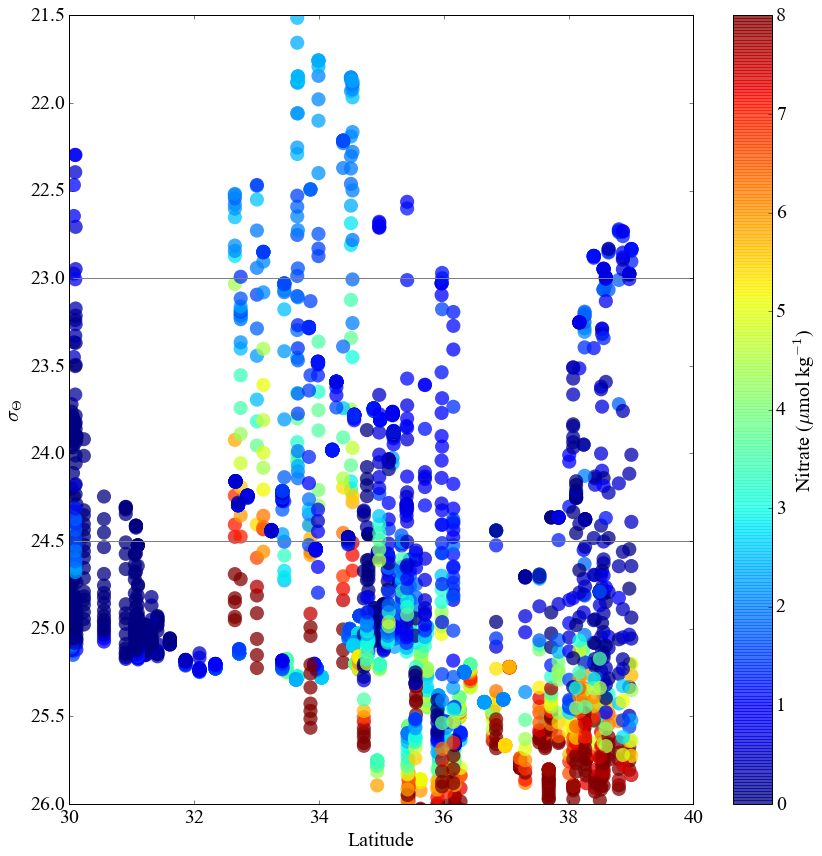

In [14]:
subset = argo[(argo['DEPTH[M]']>=-100)]# & (argo['MONTH']>5) & (argo['MONTH']<9)]
 
fig1 = plt.figure(1, figsize=(12,12))
#plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['MONTH'], s=200, vmin = 1, vmax = 12, lw=0, alpha = 0.75)
plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 8, lw=0, alpha = 0.75)
print len(pd.unique(subset['Days since 1/1/1900']))

#plt.contour()
cb = plt.colorbar(ticks = range(0, 9))
cb.set_label('Nitrate ($\mu$mol kg$^{-1}$)', fontsize = 20)
plt.gca().invert_yaxis()
plt.axis([ 30,40, 26, 21.5])

plt.axhline(23, color='grey')
plt.axhline(24.5, color='grey') 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 20)
plt.xlabel('Latitude', fontsize = 20)
plt.tick_params(labelsize=20)
cb.ax.tick_params(labelsize=20)

plt.show()

#fig1.savefig('../figures/argo_nitrate_sigma_t.png', bbox_inches='tight', dpi=600)

143


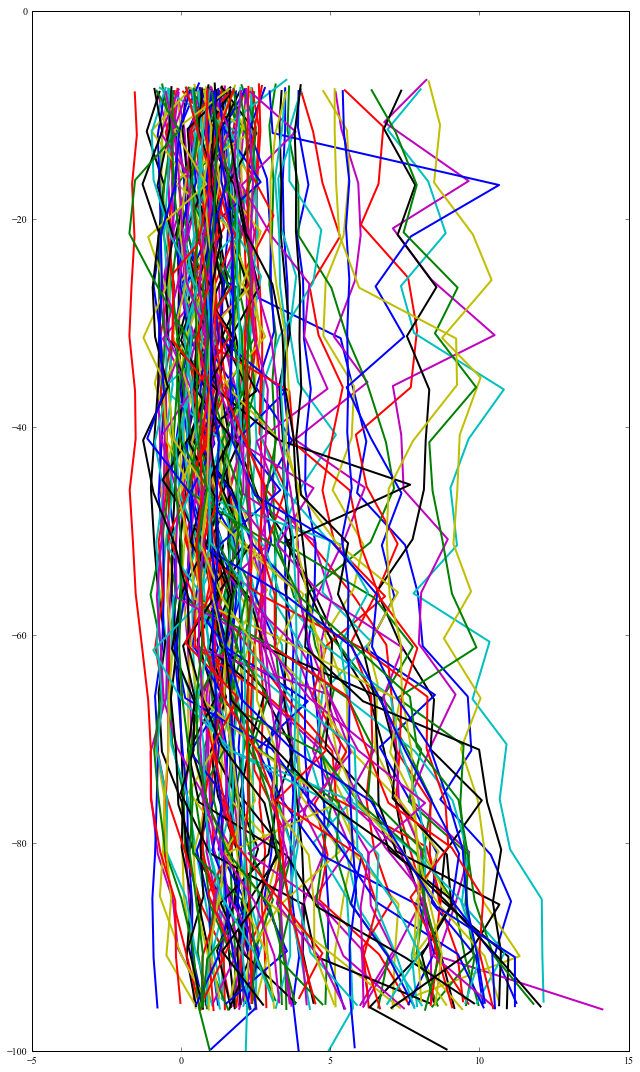

In [6]:
# get may data only
subset = argo[(argo['DEPTH[M]']>=-100)]# & (argo['MONTH']==5)]

days = pd.unique(subset['Days since 1/1/1900'])
print len(days)

fig1 = plt.figure(1, figsize=(9,15))

for d in days:
    subsetd = subset[subset['Days since 1/1/1900']==d]
    #print np.max(np.diff(subsetd['NITRATE[UMOL/KG]'].values)/np.diff(subsetd['DEPTH[M]']*-1))>0.005
    
    plt.plot(subsetd['NITRATE[UMOL/KG]'], subsetd['DEPTH[M]'], lw = 2)
plt.axis([-5, 15, -100, 0])
plt.show()